[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', '

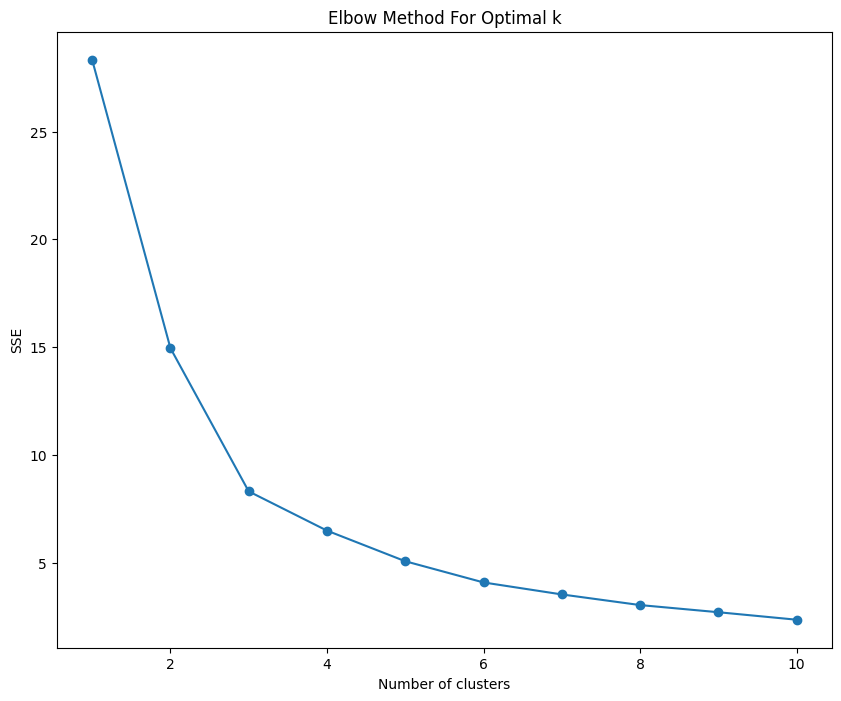

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                title           language  \
0    AfO 13, 49ff. (Narām-Sîn and the Lord of Apišal)     Old Babylonian   
1                                          Anzu OB II     Old Babylonian   
2                                         Anzu OB III     Old Babylonian   
3                                         Anzu OB III     Old Babylonian   
4                             Atraḫasis OB I (Sippar)     Old Babylonian   
..                                                ...                ...   
332             Ugaritica 5, 17d // Ugaritica 5, 17*a  Middle Babylonian   
333                                  Ugaritica 5, 17f  Middle Babylonian   
334                                  Ugaritica 5, 17h  Middle Babylonian   
335                                   Ugaritica 5, 19  Middle Babylonian   
336                                Ugaritica 7, pl. I  Middle Babylonian   

            genre  cluster  
0           Epics        1  
1           Epics        2  


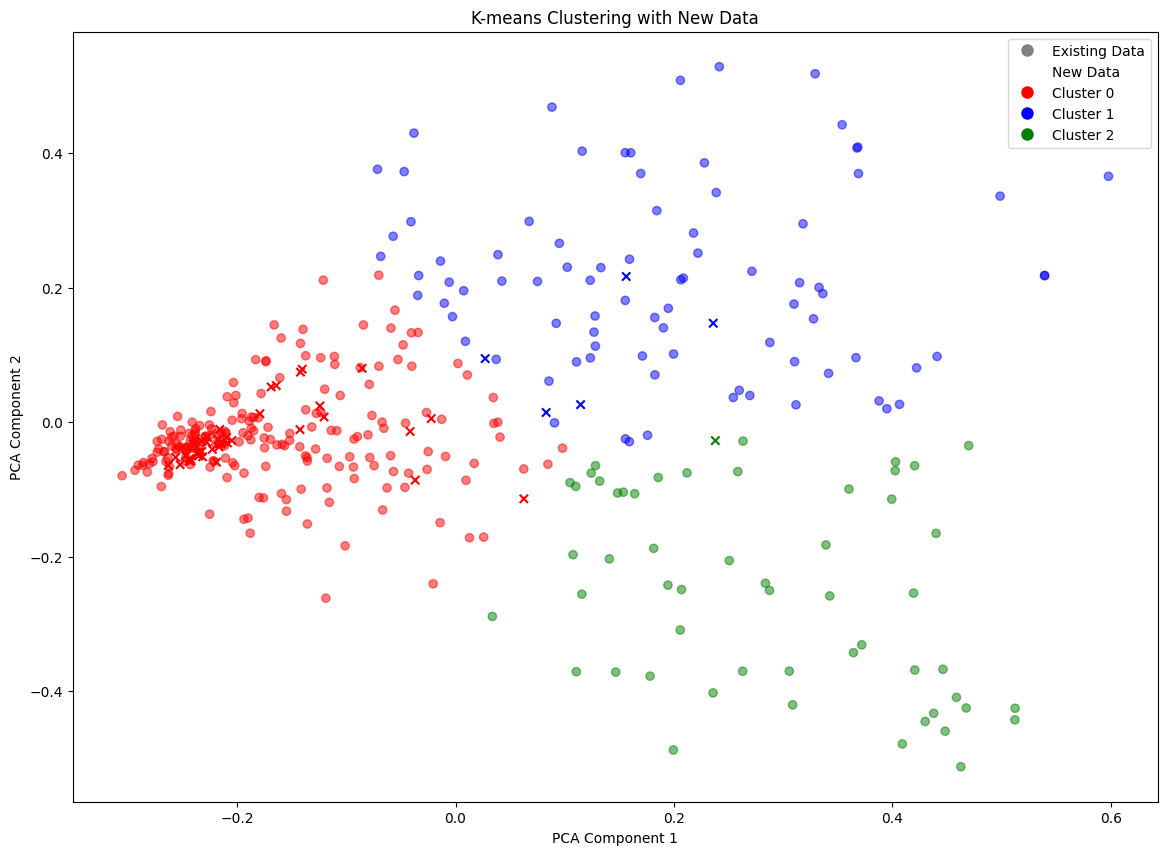

Clustering plot saved to clustering_plot.png


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt

# NLTKデータのダウンロード
nltk.download('punkt')

# 既存データの読み込み
file_path = 'Akkadian_ver2_cleaned.csv'
data = pd.read_csv(file_path)

# ステミングのための関数
stemmer = PorterStemmer()
def stemming_tokenizer(text):
    tokens = word_tokenize(text)
    return [stemmer.stem(token) for token in tokens]

# テキストデータを結合して text_combined カラムを作成
text_columns = [col for col in data.columns if col.startswith('text')]
data['text_combined'] = data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# 特徴量抽出
X = data['text_combined']

# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', tokenizer=stemming_tokenizer)
X_tfidf = vectorizer.fit_transform(X)

# PCAによる次元削減
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# エルボー法による最適なクラスタ数の決定
sse = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)

# SSEのプロット
plt.figure(figsize=(10, 8))
plt.plot(cluster_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

# エルボー法に基づく最適なクラスタ数の設定（例として3を使用）
optimal_clusters = 3

# K-meansクラスタリング
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_pca)

# 既存データにクラスタラベルを追加
data['cluster'] = kmeans.labels_

# 新しいデータの読み込み
new_file_path = 'TLA_ver2.1_cleaned.csv'
new_data = pd.read_csv(new_file_path)

# 新しいデータのベクトル化
new_X_tfidf = vectorizer.transform(new_data['text_eg'])

# 新しいデータのPCA変換
new_X_pca = pca.transform(new_X_tfidf.toarray())

# 新しいデータのクラスタ予測
new_clusters = kmeans.predict(new_X_pca)

# 結果を新しいデータフレームに追加
new_data['cluster'] = new_clusters

# 結果を表示（既存データについてはtitleカラム、languageカラム、genreカラムを、新しいデータについてはtitleカラム、genreカラムを出力）
print(data[['title', 'language', 'genre', 'cluster']])
print(new_data[['title', 'genre', 'cluster']])

# 結果をCSVファイルに保存
output_existing_data_path = 'existing_data_with_clusters.csv'
output_new_data_path = 'new_data_with_clusters.csv'
data[['title', 'language', 'genre', 'cluster']].to_csv(output_existing_data_path, index=False)
new_data[['title', 'genre', 'cluster']].to_csv(output_new_data_path, index=False)
print(f"Existing data with clusters saved to {output_existing_data_path}")
print(f"New data with clusters saved to {output_new_data_path}")

# クラスタリング結果のプロットと保存
plt.figure(figsize=(14, 10))

# クラスタごとに色を指定
colors = {0: 'red', 1: 'blue', 2: 'green'}

# プロット既存データ
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=[colors[label] for label in kmeans.labels_], alpha=0.5, label='Existing Data')

# プロット新しいデータ
scatter_new = plt.scatter(new_X_pca[:, 0], new_X_pca[:, 1], c=[colors[label] for label in new_clusters], marker='x', label='New Data')

# 凡例を手動で設定
existing_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Existing Data')
new_patch = plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='gray', markersize=10, label='New Data')
plt.legend(handles=[existing_patch, new_patch] + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {i}') for i, color in colors.items()], loc='upper right')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering with New Data')
plot_file_path = 'clustering_plot.png'
plt.savefig(plot_file_path)
plt.show()
print(f"Clustering plot saved to {plot_file_path}")
